In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from numpy.random import seed
from scipy import stats
import statsmodels.api as sm

In [2]:
# Avengers

In [3]:
Avenger = pd.read_csv("Avengers_Final.csv")
Avenger = Avenger[['Date', 'Units_Sold', 'Movie_Playing']]
Avenger.head()

,Date,Units_Sold,Movie_Playing
0,1997-04,120937,0
1,1997-05,107567,0
2,1997-06,114896,0
3,1997-07,110084,0
4,1997-08,114787,0


In [4]:
Avenger['Date'] = pd.to_datetime(Avenger['Date'])

In [5]:
Avenger.dtypes

Date             datetime64[ns]
Units_Sold                int64
Movie_Playing             int64
dtype: object

In [6]:
Avenger.set_index('Date', inplace=True)
Avenger.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-01,120937,0
1997-05-01,107567,0
1997-06-01,114896,0
1997-07-01,110084,0
1997-08-01,114787,0


In [7]:
Avenger.index

DatetimeIndex(['1997-04-01', '1997-05-01', '1997-06-01', '1997-07-01',
               '1997-08-01', '1997-09-01', '1997-12-01', '1998-01-01',
               '1998-02-01', '1998-03-01',
               ...
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=376, freq=None)

In [8]:
Avengers = Avenger.resample('M').mean()
Avengers.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,120937.0,0.0
1997-05-31,107567.0,0.0
1997-06-30,114896.0,0.0
1997-07-31,110084.0,0.0
1997-08-31,114787.0,0.0


In [9]:
Avengers.isnull().values.any()

True

In [10]:
Avengers.isnull().sum().sum()

34

In [11]:
is_NaN = Avengers.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Avengers[row_has_NaN]
print(rows_with_NaN)

            Units_Sold  Movie_Playing
Date                                 
1997-10-31         NaN            NaN
1997-11-30         NaN            NaN
2003-07-31         NaN            NaN
2003-09-30         NaN            NaN
2004-08-31         NaN            NaN
2004-10-31         NaN            NaN
2005-05-31         NaN            NaN
2006-09-30         NaN            NaN
2007-01-31         NaN            NaN
2008-01-31         NaN            NaN
2008-11-30         NaN            NaN
2015-05-31         NaN            NaN
2015-06-30         NaN            NaN
2015-07-31         NaN            NaN
2015-08-31         NaN            NaN
2015-09-30         NaN            NaN
2017-04-30         NaN            NaN


In [12]:
Avengers = Avengers.fillna(method='ffill')

In [13]:
Avengers.isnull().values.any()

False

In [14]:
#Statistics

In [15]:
np.random.seed(47)
N_rep = 10000
#Create function to run bootstrap sampling from
def bootstrap(data, func, N_rep):
    #Create empty array 
    bootstrap_rep = np.empty(N_rep)
    #Run bootstrap replicates
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep

In [16]:
#Assign movie and no-movie array
movie = np.array(Avengers[Avengers['Movie_Playing']==1].Units_Sold)
no_movie = np.array(Avengers[Avengers['Movie_Playing']==0].Units_Sold)
#Find difference in standard deviation between them
difference_std = np.std(movie) - np.std(no_movie)
difference_std

-8396.749031138399

In [17]:
#Difference of 10000 replicates
bootstrap_std = bootstrap(movie, np.std, N_rep) - bootstrap(no_movie, np.std, N_rep)
#95% confidence interval
conf_interval = np.percentile(bootstrap_std,[2.5, 97.5])
conf_interval

array([-16231.89606751,   -924.86737116])

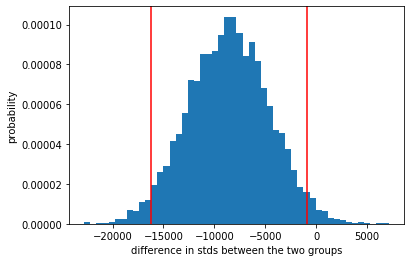

In [18]:
plt.hist(bootstrap_std, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.xlabel('difference in stds between the two groups')
plt.ylabel('probability')
plt.show()

In [19]:
# We combine the two datasets to have equal means
combined_mean = np.mean(np.concatenate((movie, no_movie)))
#Adjusting the insured and non-insured arrays 
movie_adjusted = movie - np.mean(movie) + combined_mean
no_movie_adjusted = no_movie - np.mean(no_movie) + combined_mean

In [20]:
# Bootstrap replicates
bootstrap_movie_adjusted = bootstrap(movie_adjusted, np.mean, N_rep)
bootstrap_no_movie_adjusted = bootstrap(no_movie_adjusted, np.mean, N_rep)

In [21]:
# Differences from bootstrap
bootstrap_differences = bootstrap_movie_adjusted - bootstrap_no_movie_adjusted
# Difference from data
data_difference = np.mean(movie) - np.mean(no_movie)
data_difference

-25419.198494756878

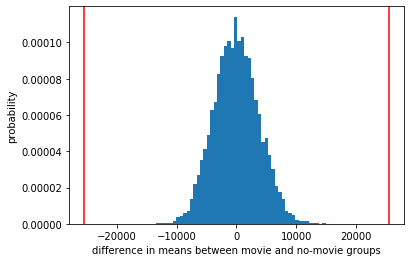

In [22]:
plt.hist(bootstrap_differences, bins=50, density=True)
plt.xlabel("difference in means between movie and no-movie groups")
plt.ylabel("probability")
plt.axvline(data_difference, color='r')
plt.axvline(-data_difference, color='r')
plt.show()

In [23]:
# P value
p_value = np.sum(bootstrap_differences >= data_difference)/ len(bootstrap_differences)
p_value

1.0

In [24]:
stats.ttest_ind(movie, no_movie, equal_var = False)

Ttest_indResult(statistic=-6.769162063705015, pvalue=2.0088032024281953e-10)

In [25]:
# Linear Regression

In [26]:
#Without Movie_Playing External Predictor

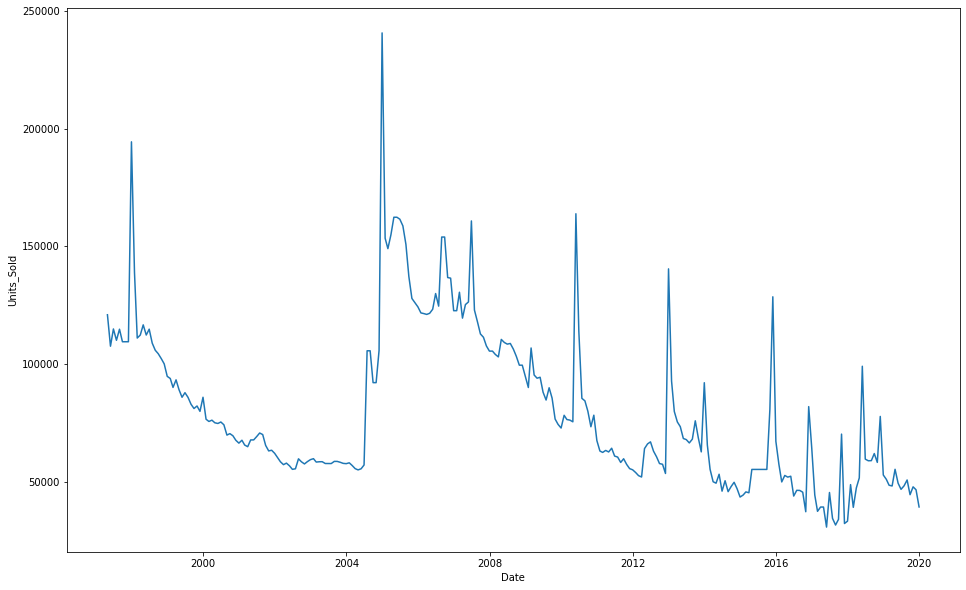

In [27]:
plt.figure(figsize=(16,10))
sns.lineplot(x=Avengers.index, y=Avengers.Units_Sold, data=Avengers)

In [28]:
train = Avengers.loc['1997-04-30':'2015-01-31']
test= Avengers.loc['2015-02-28':]

In [29]:
train.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,120937.0,0.0
1997-05-31,107567.0,0.0
1997-06-30,114896.0,0.0
1997-07-31,110084.0,0.0
1997-08-31,114787.0,0.0


In [30]:
test.head()

,Units_Sold,Movie_Playing
Date,,
2015-02-28,45632.000000,0.0
2015-03-31,45279.333333,0.0
2015-04-30,55192.000000,0.0
2015-05-31,55192.000000,0.0
2015-06-30,55192.000000,0.0


In [31]:
test_no_movie = Avengers[['Units_Sold']]
test_no_movie = test_no_movie.loc['2015-02-28':]
train_no_movie = Avengers[['Units_Sold']]
train_no_movie = train_no_movie.loc['1997-04-30':'2015-01-31']

In [32]:
train.shape

(214, 2)

In [33]:
test.shape

(59, 2)

In [34]:
#Find p, d, and q values to build ARIMA model
#P is the order of the Auto Regressive (AR) term or the number of lags of Y to be used as predictors
#D is the number of differencing required to make the time series stationary
#Q is the order of the Moving Average (MA) term or the number of lagged forecast errors that should go into the ARIMA model

In [35]:
#ARIMA

In [36]:
#Auto ARIMA Forecast to choose best p,d,q
model_train_arima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_arima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4754.486, BIC=4767.931, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4784.212, BIC=4790.935, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4765.582, BIC=4775.665, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4754.258, BIC=4764.342, Time=0.019 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=4782.299, BIC=4785.661, Time=0.006 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=4755.575, BIC=4769.020, Time=0.031 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=4757.314, BIC=4774.120, Time=0.075 seconds
Total fit time: 0.242 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2374.129
Date:                Sat, 01 Aug 2020   AIC  

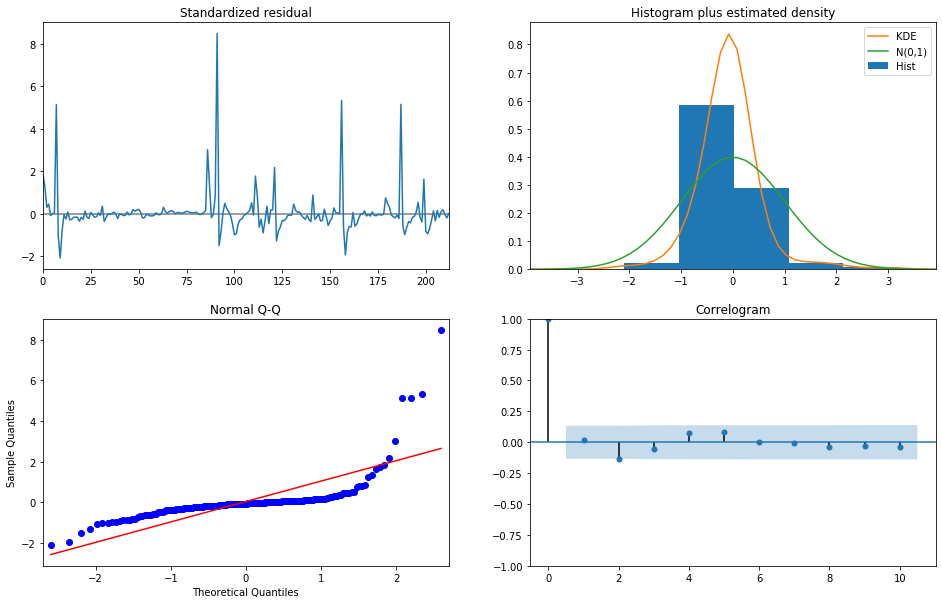

In [37]:
model_train_arima.plot_diagnostics(figsize=(16,10))
plt.show()

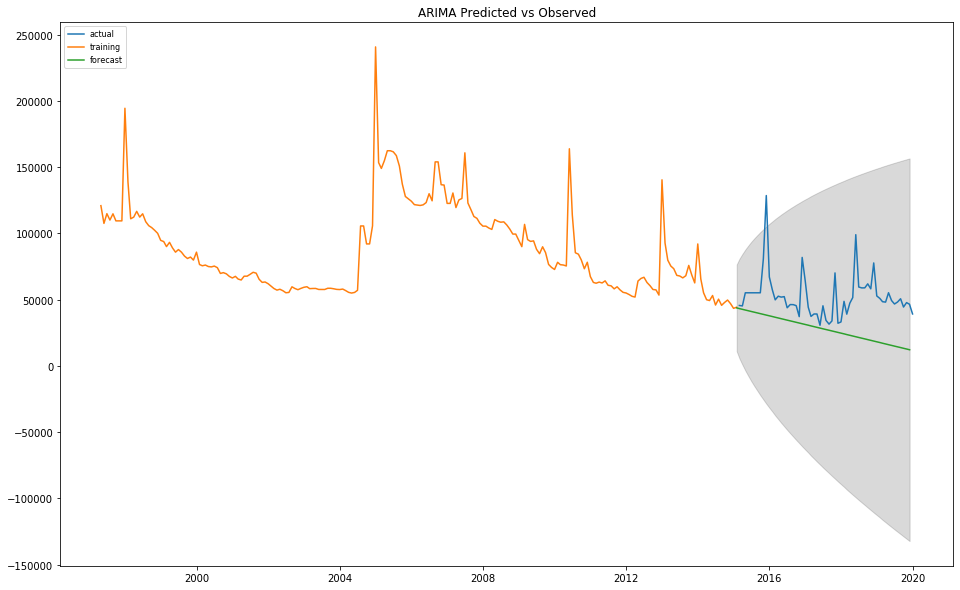

In [38]:
# Forecast
n_periods_arima = 59
fc_arima, confint_arima = model_train_arima.predict(n_periods=n_periods_arima, return_conf_int=True)
index_of_fc_arima = pd.date_range(train.index[-1], periods = n_periods_arima, freq='MS')

# make series for plotting purpose
fc_series_arima = pd.Series(fc_arima, index=index_of_fc_arima)
lower_series_arima = pd.Series(confint_arima[:, 0], index=index_of_fc_arima)
upper_series_arima = pd.Series(confint_arima[:, 1], index=index_of_fc_arima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_arima, label='forecast')
plt.fill_between(lower_series_arima.index, lower_series_arima, upper_series_arima, color='k', alpha=.15)
plt.title("ARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mean_absolute_percentage_error(test_no_movie, fc_series_arima)

44.11303175551301

In [41]:
#SARIMA

In [42]:
#Auto SARIMA Forecast to choose best p,d,q
model_train_sarima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4567.448, BIC=4583.990, Time=0.472 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4774.322, BIC=4780.938, Time=0.023 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4599.537, BIC=4612.770, Time=0.254 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4680.585, BIC=4693.818, Time=0.271 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=4776.192, BIC=4779.500, Time=0.024 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4636.855, BIC=4650.088, Time=0.164 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4568.559, BIC=4588.408, Time=0.634 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4569.396, BIC=4589.245, Time=1.513 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4588.677, BIC=4605.218, Time=0.453 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4563.845, BIC=4587.002, Time=3.639 seconds
Near non-invertible roots 

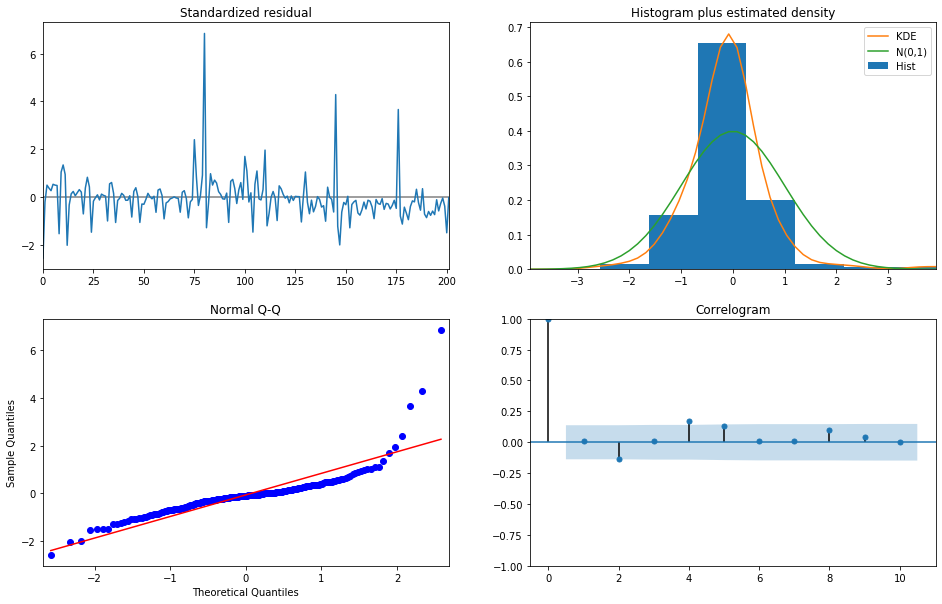

In [43]:
model_train_sarima.plot_diagnostics(figsize=(16,10))
plt.show()

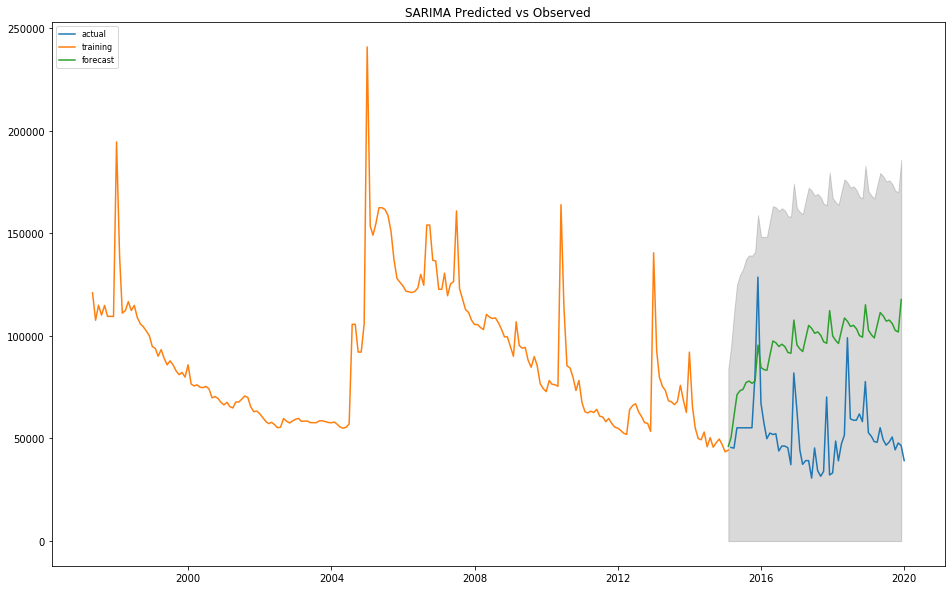

In [44]:
# Forecast
n_periods_sarima = 59
fc_sarima, confint_sarima = model_train_sarima.predict(n_periods=n_periods_sarima, return_conf_int=True)
index_of_fc_sarima = pd.date_range(train.index[-1], periods = n_periods_sarima, freq='MS')

# make series for plotting purpose
fc_series_sarima = pd.Series(fc_sarima, index=index_of_fc_sarima)
lower_series_sarima = pd.Series(confint_sarima[:, 0], index=index_of_fc_sarima)
upper_series_sarima = pd.Series(confint_sarima[:, 1], index=index_of_fc_sarima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_sarima, label='forecast')
plt.fill_between(upper_series_sarima.index, upper_series_sarima, color='k', alpha=.15)
plt.title("SARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarima)

96.5854131763795

In [46]:
# With Movie_Playing External Predictor

In [47]:
#SARIMAX

In [48]:
#Auto SARIMAX Forecast to choose best p,d,q
model_train_sarimax = pm.auto_arima(train[['Units_Sold']], exogenous=train[['Movie_Playing']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarimax.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4570.391, BIC=4590.241, Time=0.537 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4776.315, BIC=4786.240, Time=0.047 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4602.132, BIC=4618.674, Time=0.343 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4665.610, BIC=4682.151, Time=0.978 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=5648.934, BIC=5655.550, Time=0.048 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4640.121, BIC=4656.662, Time=0.203 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4571.463, BIC=4594.621, Time=0.767 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4572.322, BIC=4595.480, Time=1.967 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4591.333, BIC=4611.183, Time=0.499 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4566.932, BIC=4593.398, Time=4.254 seconds
Near non-invertible roots 

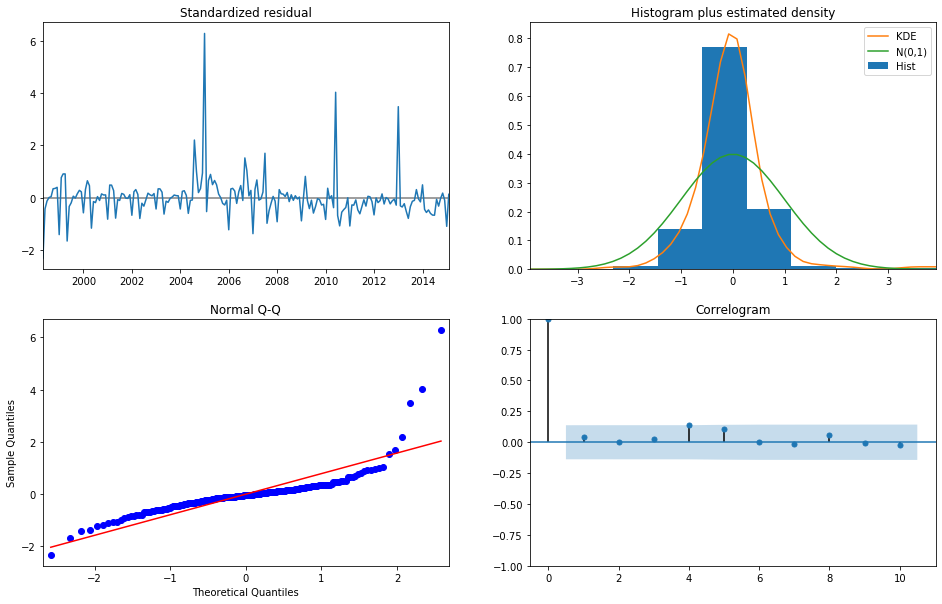

In [49]:
model_train_sarimax.plot_diagnostics(figsize=(16,10))
plt.show()

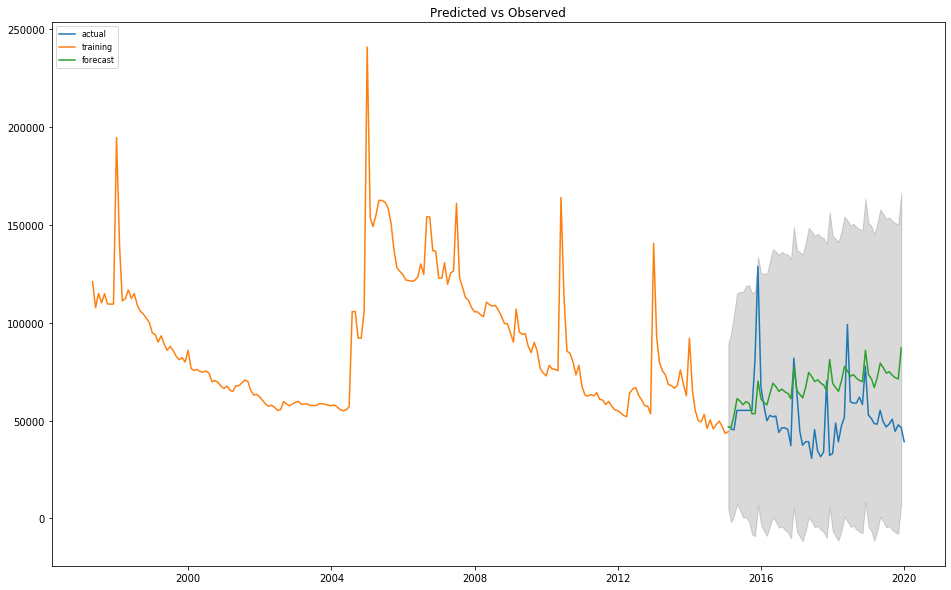

In [50]:
# Forecast
n_periods_sarimax = 59
fc_sarimax, confint_sarimax = model_train_sarimax.predict(n_periods=n_periods_sarimax, exogenous=test[['Movie_Playing']], 
                                                          return_conf_int=True)
index_of_fc_sarimax = pd.date_range(train.index[-1], periods = n_periods_sarimax, freq='MS')

# make series for plotting purpose
fc_series_sarimax = pd.Series(fc_sarimax, index=index_of_fc_sarimax)
lower_series_sarimax = pd.Series(confint_sarimax[:, 0], index=index_of_fc_sarimax)
upper_series_sarimax = pd.Series(confint_sarimax[:, 1], index=index_of_fc_sarimax)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test[['Units_Sold']], label='actual')
plt.plot(train[['Units_Sold']], label='training')
plt.plot(fc_series_sarimax, label='forecast')
plt.fill_between(lower_series_sarimax.index, lower_series_sarimax, upper_series_sarimax, color='k', alpha=.15)
plt.title("Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarimax)

43.8899474994011